# Project 3: Classification with Logistic Regression and SVM

Before we start, please put your name and CUID in following format

: Firstname LASTNAME, #00000000   //   e.g. Nianyi LI, #12345678

**Your Answer:**   
OMKAR MAYEKAR, #C15673768

# General Rules of the Project Submission

Python 3 and [Matplotlib](https://matplotlib.org/) will be used throughout the semseter, so it is important to be familiar with them. It is strongly suggested to go through [Stanford CS231n](http://cs231n.github.io/python-numpy-tutorial/) and [CS228](https://github.com/kuleshov/cs228-material/blob/master/tutorials/python/cs228-python-tutorial.ipynb) for more detailed Python and numpy tutorials if you haven't had used Python before. 

In some cells and files you will see code blocks that look like this:

```python
##############################################################################
#                    TODO: Write the equation for a line                     #
##############################################################################
pass
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:

```python
##############################################################################
#                    TODO: Write the equation for a line                     #
##############################################################################
y = m * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks
- Follow the instruction of the project description carefully
- Run all cells before submitting. <span style="color:red">**You will only get credit for code that has been run!**.</span>

The last point is extremely important and bears repeating:

### We will not re-run your notebook -- <span style="color:red">you will only get credit for cells that have been run</span>

### File name
Your Python program should be named **yourlastname_yourfirstname_P3.ipynb**, then zip it and upload to Canvas

# Project Description

For this project we will apply both **Logistic Regression** and **SVM** to predict whether capacitors from a fabrication plant pass quality control based (QC) on two different tests. To train your system and determine its reliability you have a set of 118 examples. The plot of these examples is show below where a red x is a capacitor that failed QC and the green circles represent capacitors that passed QC.

<div>
<img src="https://nianyil.people.clemson.edu/CPSC_4430/P3_new.png" width="500"/>
</div>


## Data File

Two text files with the data is available on Canvas: a training set of 85 examples and a test set of 33 examples. Both are formatted as
- First line: **m** and **n**, tab separated
- Each line after that has two real numbers representing the results of the two tests, followed by a *1.0* if the capacitor *passed* QC and a *0.0* if it *failed* QC—tab separated.

You need to write a code to read data from the file. You **can** use packages, such as **panda**, to load the data.


In [67]:
##############################################################################
#         TODO: Write the code for reading data from file                    #
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Load the data (skip the first line and provide appropriate column names)
train = pd.read_csv('P3train.txt', delim_whitespace=True, skiprows=1, names=['x1', 'x2', 'y'])
test = pd.read_csv('P3test.txt', delim_whitespace=True, skiprows=1, names=['x1', 'x2', 'y'])

# Separate features and labels
X_train = train[['x1', 'x2']]
y_train = train['y'].values.reshape(1, -1)  # Reshape for compatibility
X_test = test[['x1', 'x2']]
y_test = test['y'].values.reshape(1, -1)
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Your assignment is to use what you have learned from the class slides and homework to create (**from scratch in Python**, not by using Logistic Regression library function!) a **Logistic Regression** and **SVM** binary classifier to predict whether each capacitor in the test set will pass QC. 

## Logistic Regression

You are free to use any model variation and any testing or training approach we have discussed for logistic regression. In particular, since this data is not linear, I assume you will want to add new features based on power of the original two features to create a good decision boundary. $w_0 + w_1x_1 + w_2x_2$ is not going to work!
One choice might be
- $\textbf{w}^T \textbf{x} = w_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5 +w_6x_6 + w_7x_7 + w_8x_8$    where the new features are created as follows:

| New Features |From Original Features |
| --- | --- |
|$x_1$	| $x_1$|
|$x_2$	| $x_1^2$|
|$x_3$	| $x_2$||
|$x_4$	| $x_1x_2$|
|$x_5$	| $x_1x_2^2$|
|$x_6$	| $x_2^2$|
|$x_7$	| $x_1^2x_2$|
|$x_8$	| $x_1^2x_2^2$|

Note that it is easy to create a small Python program that reads in your  original features, uses a nested loop to create the new features and then writes them to a file:

```python
thePower = 2
for j in range(thePower+1): 
    for i in range(thePower+1):
        temp = (x1**i)*(x2**j)
        if (temp != 1):
            fout1.write(str(temp)+"\t") fout1.write(str(y)+"\n")
```

With a few additions to the code, you can make a program to create combinations of any powers of $x_1$ and $x_2$!

In [68]:
##############################################################################
#           TODO: Define the Logistic regression models                      #
##############################################################################
# Generate polynomial features according to the provided image
def generate_polynomial_features(X, degree=10):
    x1 = X['x1']
    x2 = X['x2']
    
    # Initialize an empty dictionary to hold new features
    poly_features = {'x1^0 * x2^0': np.ones(len(x1))}  # Start with a column of ones for bias term
    
    # Create polynomial features up to the specified degree
    for i in range(1, degree + 1):
        for j in range(i + 1):
            feature_name = f'x1^{i-j} * x2^{j}'
            poly_features[feature_name] = (x1**(i-j)) * (x2**j)
    
    return pd.DataFrame(poly_features)

# Apply feature generation to training and test data


X_train_poly = generate_polynomial_features(X_train,degree=10).T  # Transpose for compatibility
X_test_poly = generate_polynomial_features(X_test,degree=10).T  # Transpose for compatibility



# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the logistic regression model with gradient descent
def model(X, Y, learning_rate, iterations):
    m = X.shape[1]  # Number of examples
    n = X.shape[0]  # Number of features
    
    # Initialize weights and bias
    W = np.zeros((n, 1))
    B = 0
    cost_list = []
    
    for i in range(iterations):
        # Forward propagation
        Z = np.dot(W.T, X) + B
        A = sigmoid(Z)
        
        # Cost function
        cost = -(1/m) * np.sum(Y * np.log(A + 1e-9) + (1 - Y) * np.log(1 - A + 1e-9))  # Avoid log(0)
        
        # Gradient Descent
        dW = (1/m) * np.dot(X, (A - Y).T)
        dB = (1/m) * np.sum(A - Y)
        
        # Update weights and bias
        W = W - learning_rate * dW
        B = B - learning_rate * dB
        
        # Keep track of cost
        cost_list.append(cost)
        
        if i % (iterations // 10) == 0:
            print(f"Cost after {i} iterations: {cost}")
    
    return W, B, cost_list

# Train the model using the generated polynomial features
W, B, cost_list = model(X_train_poly.values, y_train, learning_rate=0.01, iterations=100000)


# Prediction function
def predict(X, W, B):
    Z = np.dot(W.T, X) + B
    A = sigmoid(Z)
    return A >= 0.555  # Threshold to classify as 0 or 1

# Calculate accuracy
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

# Predict on test data
y_test_pred = predict(X_test_poly.values, W, B)
test_accuracy = accuracy(y_test_pred, y_test)

print("Test Accuracy:", test_accuracy)


##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Cost after 0 iterations: 0.6931471785599455
Cost after 10000 iterations: 0.4489912600608603
Cost after 20000 iterations: 0.3996946918644609
Cost after 30000 iterations: 0.37635190440989824
Cost after 40000 iterations: 0.36278832206646516
Cost after 50000 iterations: 0.3539825712882967
Cost after 60000 iterations: 0.34783941665323553
Cost after 70000 iterations: 0.3433317989323713
Cost after 80000 iterations: 0.33989521588565913
Cost after 90000 iterations: 0.33719194350291637
Test Accuracy: 0.8484848484848485


## Optimization using Gradient Decent

Once you have defined the logistic regression model, you need to find the weights using the Gradient Decent algorithm. You need to implement the Vanilla Gradient Decent from scratch in Python.

You need to specify the hyperparameters of GD, and plot the training loss curve (**J-curve**). The loss function should be the binary cross-entropy loss function that we introduced.

In [69]:
##############################################################################
#           TODO: Implement the Gradient Decent Algorithm                    #
##############################################################################
# Define the hyperparameters:
# Numbers of epoch (epoch_num), learning rate (lr), and the initial weights(w)
epoch_num = 1000000
lr = 0.001
m, n = X_train_poly.values.shape
w = np.zeros((n, 1))
X_train_poly = generate_polynomial_features(train[['x1', 'x2']], degree=10)
y_train = train['y'].values.reshape(-1, 1)

# Define the loss:
def cross_entropy_loss(y_pred, y):
    m = y.shape[0]
    J = -(1/m) * np.sum(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
    return J

# Calculate the gradient function:
def gradient_func(X, y_pred, y):
    m = y.shape[0]
    gradient_value = (1/m) * np.dot(X.T, (y_pred - y))
    return gradient_value

# Implement the Gradient decent algorithm using for loop
def Vanilla_GD(X, y, epoch_num, lr):
    m, n = X.shape
    w = np.zeros((n, 1))  # Initialize weights with shape (n, 1)
    b = 0  # Initialize bias as zero
    cost_list = []

    for epoch in range(epoch_num):
        z = np.dot(X, w) + b
        y_pred = sigmoid(z)
        
        # Calculate the loss (cross-entropy)
        J = cross_entropy_loss(y_pred, y)
        
        # Save the cost for plotting
        cost_list.append(J)
        
        # Calculate gradients
        dw = gradient_func(X, y_pred, y)
        db = (1/m) * np.sum(y_pred - y)
        
        # Update weights and bias
        w -= lr * dw
        b -= lr * db
        
    
    return w, b, cost_list

final_weights, final_bias, cost_list = Vanilla_GD(X_train_poly.values, y_train, epoch_num, lr)

##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Next, print out the final weights and plot the **J-curve/Loss curve** of training. 

[[ 1.59363260e+00]
 [ 1.99270090e+00]
 [ 3.24032400e+00]
 [-4.92946273e+00]
 [-5.08466633e+00]
 [-4.99550621e+00]
 [ 7.63244192e-01]
 [-1.71153097e+00]
 [-3.17914839e-03]
 [-7.73711360e-01]
 [-3.49019430e+00]
 [-2.19992482e-01]
 [-2.47291468e+00]
 [-1.04478191e+00]
 [-3.33287590e+00]
 [-3.32687367e-01]
 [-9.26334606e-01]
 [ 6.22882221e-01]
 [-1.56112177e+00]
 [-7.56449596e-01]
 [ 5.11174329e-02]
 [-2.54808432e+00]
 [-9.54922314e-02]
 [-9.77401603e-01]
 [ 5.03671425e-01]
 [-1.60898088e+00]
 [-5.54620406e-01]
 [-1.44585542e+00]
 [-7.17405111e-01]
 [-4.82515243e-01]
 [ 1.36837571e-01]
 [-5.65889532e-01]
 [ 3.29058894e-01]
 [-9.46455554e-01]
 [-8.66467055e-01]
 [ 7.14132507e-01]
 [-1.89153380e+00]
 [-1.35021413e-02]
 [-4.71996192e-01]
 [ 1.68981674e-01]
 [-5.62583916e-01]
 [ 4.01572726e-01]
 [-1.00107543e+00]
 [-5.00777382e-01]
 [-2.89440584e-01]
 [-7.98677936e-01]
 [-2.36911586e-01]
 [-1.83031132e-02]
 [-2.15169791e-01]
 [ 8.90914093e-02]
 [-3.31912679e-01]
 [ 2.09619000e-01]
 [-5.7846000

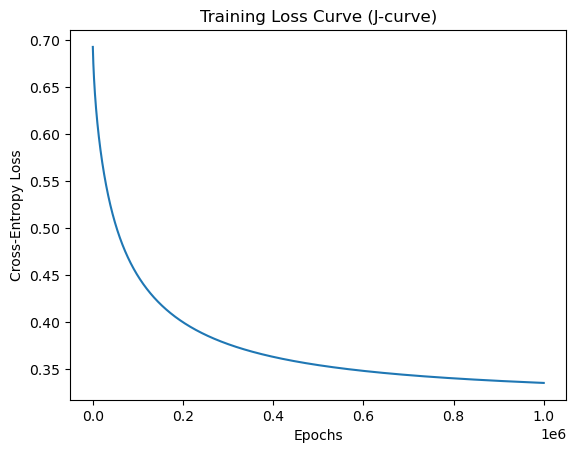

In [70]:
##############################################################################
#                     TODO: Plot the J curve                                 #
##############################################################################
# Print out the final weights
print(final_weights)

# Plot the J curve w.r.t. the iteration numbers
plt.plot(range(epoch_num), cost_list)
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss Curve (J-curve)")
plt.show()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Based on your data and plot, you should then briefly discuss how you can ensure that the model is well trained.

**Your Answer:**  The curve shows a steady decrease in the cross-entropy loss, meaning the model is learning effectively. It’s approaching a minimum as the slope levels off, suggesting that the model is nearing convergence.Finally, evaluating the model on a separate test dataset will provide insight into its performance on unseen data, helping us confirm that the model is well-trained and generalizes effectively.



## Model Evaluation

Evaluate the performance on testing set:
- Print out the confusion matrix
- Calculate and print out the *accuracy*, *precision*, *recall*, and *F1* value of your model

**Note that:**
- For **undergrads** *(CPSC 4430)* the final accuracy of both algorithms on your test set should be higher than  <span style="color:red">**70%**</span>
- For **graduate-level** *(CPSC 6430)* the final accuracy of both algorithms on your test set should be higher than  <span style="color:red">**85%**</span>


In [71]:
##############################################################################
#                           TODO: Model Evaluation                           #
##############################################################################
# Prepare the test data
test = pd.read_csv('P3test.txt', delim_whitespace=True, skiprows=1, names=['x1', 'x2', 'y'])
X_test_poly = generate_polynomial_features(test[['x1', 'x2']], degree=10)
y_test = test['y'].values.reshape(-1, 1)

# Prediction function for logistic regression
def predict(X, W, B):
    Z = np.dot(X, W) + B  # X has shape (number_of_samples, number_of_features) and W has shape (number_of_features, 1)
    A = sigmoid(Z)
    return (A >= 0.5).astype(int).flatten()  # Flatten for compatibility

# Predict on the test data
y_test_pred = predict(X_test_poly.values, final_weights, final_bias)
y_test_actual = y_test.flatten()  # Flatten to ensure it's a 1D array

# Confusion Matrix and Metrics Calculation
TP = np.sum((y_test_pred == 1) & (y_test_actual == 1))  # True Positives
TN = np.sum((y_test_pred == 0) & (y_test_actual == 0))  # True Negatives
FP = np.sum((y_test_pred == 1) & (y_test_actual == 0))  # False Positives
FN = np.sum((y_test_pred == 0) & (y_test_actual == 1))  # False Negatives

# Print the confusion matrix
print("Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
print([[TN, FP], [FN, TP]])

# Calculate and print evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Confusion Matrix:
TP: 15, FP: 4, TN: 13, FN: 1
[[13, 4], [1, 15]]
Accuracy: 84.85%
Precision: 0.7895
Recall: 0.9375
F1 Score: 0.8571


## Support Vector Machine (SVM)

In this part, you need to use the previous training and testing data file. 

You are **allowed** to use the svm functions in the **Scikit-learn** library and don’t need to implement the algorithm from scratch.

- You need to try at least **three** different kernel functions of SVM, and pick the **best** model.
- You need to print out the final weights got from your best SVM model.

**Note that:**
- For **undergrads** *(CPSC 4430)* the final accuracy of both algorithms on your test set should be higher than  <span style="color:red">**70%**</span>
- For **graduate-level** *(CPSC 6430)* the final accuracy of both algorithms on your test set should be higher than  <span style="color:red">**85%**</span>

In [72]:
##############################################################################
#                      TODO: Classfication using SVM                         #
##############################################################################
# Pick the best model
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Load the training and testing data
# Load the data from text files using pandas
train = pd.read_csv('P3train.txt', delim_whitespace=True, skiprows=1, names=['x1', 'x2', 'y'])
test = pd.read_csv('P3test.txt', delim_whitespace=True, skiprows=1, names=['x1', 'x2', 'y'])

# Separate the features (x1, x2) and labels (y)
X_train = train[['x1', 'x2']]
y_train = train['y']
X_test = test[['x1', 'x2']]
y_test = test['y']

# Step 2: Try different SVM kernels
# We will test 3 kernels: 'linear', 'poly', and 'rbf'
kernels = ['linear', 'poly', 'rbf']
best_accuracy = 0  # To store the best accuracy we find
best_kernel = None  # To store the best kernel name
best_model = None  # To store the best SVM model

# Loop through each kernel
for kernel in kernels:
    # Create the SVM model with the given kernel
    svm = SVC(kernel=kernel, C=1.0)
    svm.fit(X_train, y_train)  # Train the model on the training data
    
    # Predict on the test data
    y_pred = svm.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Kernel: {kernel}, Accuracy: {accuracy:.4f}")  # Print accuracy for each kernel
    
    # Check if this is the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_kernel = kernel
        best_model = svm  # Store the model with the best performance

# Step 3: Print the best kernel and its accuracy
print(f"\nBest Kernel: {best_kernel}, Best Accuracy: {best_accuracy:.4f}")



# Increasing Accuracy of best model
svm_rbf = SVC(kernel='rbf', C=10, gamma=0.5)  # Adjust C and gamma
svm_rbf.fit(X_train, y_train)
y_pred = svm_rbf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'Accuracy of rbf after adjusting C and Gamma : {accuracy_score(y_test, y_pred)*100:.2f}%')

# Print out the final weights
if best_kernel == 'linear':
    print("Final weights (coefficients) from the best SVM model:", best_model.coef_)
else:
    print("For non-linear kernels (poly, rbf), weights are not directly accessible.")
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Kernel: linear, Accuracy: 0.4545
Kernel: poly, Accuracy: 0.6667
Kernel: rbf, Accuracy: 0.8485

Best Kernel: rbf, Best Accuracy: 0.8485
Accuracy of rbf after adjusting C and Gamma : 87.88%
For non-linear kernels (poly, rbf), weights are not directly accessible.


## Visualize Decision Boundary and Model Comparision

You need to plot the decision boundary of Logistic Regression and SVM that you previously trained separately. 

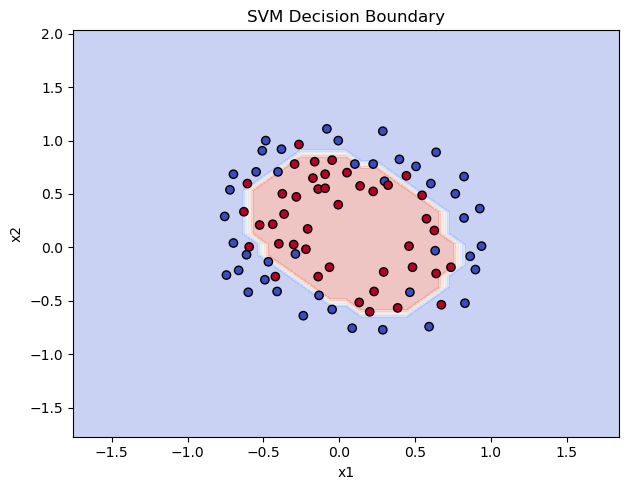

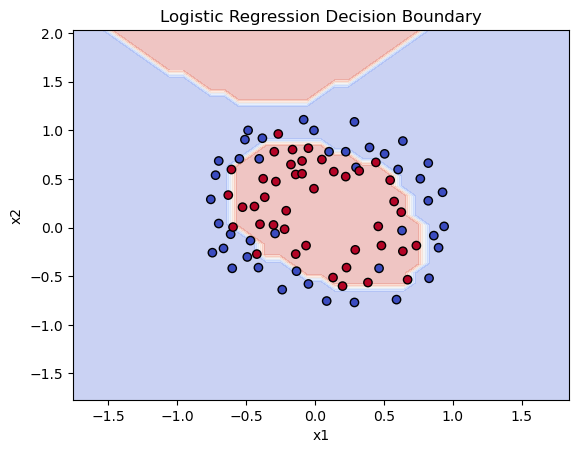

In [73]:
##############################################################################
#                   TODO: Plot the Decision Boundary                         #
##############################################################################
def plot_decision_boundary(model, X, y, title):
    # Define the mesh grid limits based on the data range
    x_min, x_max = X['x1'].min() - 1, X['x1'].max() + 1
    y_min, y_max = X['x2'].min() - 1, X['x2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict on the grid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and the original points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X['x1'], X['x2'], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")


# Create subplots
plt.figure(figsize=(12, 5))

# Plot SVM decision boundary
plt.subplot(1, 2, 2)
plot_decision_boundary(svm_rbf, X_train, y_train, "SVM Decision Boundary")

plt.tight_layout()
plt.show()

# Function to plot decision boundary
def plot_decision_boundary(X, y, W, B, degree=10):
    # Convert y to a NumPy array and reshape if necessary
    y = y.values.ravel()  # Convert to NumPy array and flatten to 1D

    # Create a mesh grid based on the feature space
    x_min, x_max = X['x1'].min() - 1, X['x1'].max() + 1
    y_min, y_max = X['x2'].min() - 1, X['x2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Flatten the grid to pass through the model
    grid_points = pd.DataFrame({'x1': xx.ravel(), 'x2': yy.ravel()})
    
    # Generate polynomial features for the grid points (same degree as used during training)
    X_poly_grid = generate_polynomial_features(grid_points, degree=degree)
    
    # Compute predictions for each point in the grid
    Z = np.dot(X_poly_grid.values, W) + B  # Compute the linear combination
    Z = sigmoid(Z)  # Apply the sigmoid to get probabilities
    Z = (Z >= 0.5).astype(int)  # Classify based on threshold 0.5
    Z = Z.reshape(xx.shape)  # Reshape predictions back to the grid shape

    # Plot decision boundary and data points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X['x1'], X['x2'], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Logistic Regression Decision Boundary")

# Plot the decision boundary
plot_decision_boundary(train[['x1', 'x2']], y_train, final_weights, final_bias, degree=10)
plt.show()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

Based on your data and plot, you should then briefly discuss which one has better performance and why.

**Your Answer :**  Based on the decision boundary plots, the SVM model performs better than the Logistic Regression model. The SVM decision boundary closely follows the shape of the data distribution, capturing the non-linear separation effectively. In contrast, Logistic Regression shows some areas that are misclassified due to its limitations in modeling complex boundaries without sufficient polynomial features. This suggests SVM is more suitable for this dataset, especially when non-linear patterns are present.